<a href="https://colab.research.google.com/github/fabiorfc/Epidemiologia-Matematica/blob/master/Modelagem_SIR_Vis%C3%A3o_di%C3%A1ria_S%C3%A3o_Paulo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análises preliminares

Neste notebook fooram avaliadas as curvas de incidência, prevalência e letalidade de casos de coronavírus da cidade de São Paulo.

Além disso, também foi estimada a curva SIR, modelo compartimental que segmenta a população em Suscetíveis, Infectados e Removidos.

___
## 1) Escopo do notebook

* i. Definição das equações diferenciais
* ii. Preparação do ambiente
* iii. Avaliação das curvas de prevalência
* iiii. Modelagem SIR

## 1.1) Definição da dinâmica entre os compartimentos populacionais

Para este trabalho, a dinâmica entre os compartimentos populacionais será defido da seguinte forma:

Suscetíveis -- $^{\beta * S(t) * I(t) * N^{-1}}$ --> Infectados

Infectados -- $^{I(t) * (d + \gamma)}$ --> Removidos

Aqui, serão considerados como removidos do grupo de infectados, os indivíduos recuperados e aqueles que não resistiram ao sintomas mais graves.

As equações diferenciais que definem a dinâmica proposta neste trabalho é:

**Variação da população Suscetível:**
>\begin{equation}
\frac {d S(t)}{dt} = -\frac{\beta I(t)  S(t)}{N} \tag{1}
\end{equation}

**Variação da população de Infectados:**
>\begin{equation}
\frac {d I(t)}{dt} = \frac{\beta I(t)  S(t)}{N}  - I(t) (d + \gamma) \tag{2}
\end{equation}

**Variação da população de Infectados:**
>\begin{equation}
\frac {d R(t)}{dt} = I(t) (d + \gamma) \tag{3}
\end{equation}



___
## 2) Preparação do ambiente

### 2.1) Libraries utilizadas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 2.2) Leitura dos dados

In [2]:
sao_paulo = pd.read_csv('sao_paulo.csv')
sao_paulo = sao_paulo.query("infectados > 0")
sao_paulo.tail(2)

,regiao,estado,municipio,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,infectados,infectados_log,infectados_uti,data_estimada_acometimento,letalidade_01,prevalencia,incidencia
158,Sudeste,SP,São Paulo,SAO PAULO,2020-09-01,36,12252023.0,260991,3042,11478,70,NaN,831739.130435,13.631274,50736.086957,2020-08-14,0.043979,2130.186990,24.828553
159,Sudeste,SP,São Paulo,SAO PAULO,2020-09-02,36,12252023.0,262570,1579,11554,76,NaN,837246.376812,13.637874,51072.028986,2020-08-15,0.044004,2143.074658,12.887668


### 2.3) Funções

In [3]:
def series_de_acometidos(cidade, variavel, tempo):
    """Funcao para gerar a serie de acometidos"""
    acometidos, acometidos_teorico, acometidos_observados, duracao_pandemia = [], [], [], []
    for i in range(len(cidade) + tempo):
        if i == 0:
            acometidos.append(1)
            acometidos_teorico.append(1)
            acometidos_observados.append(np.nan)
            duracao_pandemia.append(i)
        elif i > 0 and i <= tempo:
            acometidos.append(np.nan)
            acometidos_teorico.append(np.nan)
            acometidos_observados.append(np.nan)
            duracao_pandemia.append(i)
        elif i > tempo:
            acometidos.append(cidade[variavel][i-tempo])
            acometidos_teorico.append(np.nan)
            acometidos_observados.append(cidade[variavel][i-tempo])
            duracao_pandemia.append(i)    
    return acometidos, acometidos_teorico, acometidos_observados, duracao_pandemia

def R_0(beta, gamma, d):
      """Funcoes para calcular o valor de R0"""
      return beta / (gamma + d)

def EDO(y, t, N, beta, gamma, d):
      """Funcao para gerar as curvas SIR"""
      S, I, R = y
      dSdt = -beta * S * I / N
      dIdt = beta * S * I / N - I * (gamma + d)
      dRdt = I * (gamma + d)
      return dSdt, dIdt, dRdt

def estimativa_de_beta_SIR(vetor_treino, tempo):
    """Funcao para estimar o melhor valor de beta da curva SIR"""
    # Parametros necessarios
    dimensao_vetor = len(vetor_treino)
    passos = int(tempo[-1])

    lista_resultados = []
    for beta in betas:
          # Integracao do modelo SIR
          ret = odeint(EDO, y0, t, args=(N, beta, gamma, d))
          _, I, _ = ret.T

          # Ajuste do tempo para estimar o estágio da pandemia
          for i in range(passos-dimensao_vetor):
              mse = mean_squared_error(I[i:dimensao_vetor+i], vetor_treino)
              lista_resultados.append((mse, beta, i))

    # Gerando os resultados
    tabela_final = pd.DataFrame(lista_resultados, columns = ['MSE','Beta','Tempo'])

    # Gerando o melhor beta e o tempo mais adequado
    melhores_resultados = tabela_final[tabela_final['MSE'] == min(tabela_final['MSE'])]

    # Extraindo os valores das estimativas
    melhor_beta = melhores_resultados['Beta'].values[0]
    melhor_tempo = melhores_resultados['Tempo'].values[0]

    print("Resumo das estimativas")
    print(" --- Beta: {}".format(melhor_beta))
    print(" --- O tempo mais adequado foi {}".format(melhor_tempo))

    return melhor_beta, melhor_tempo

___
## 3) Análise simultânea das Cidades

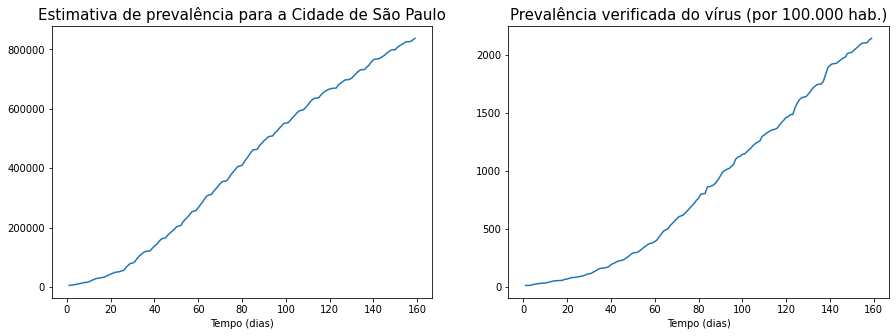

In [4]:
#Curvas de demandas por leitos de UTI
fig, axs = plt.subplots(1,2, figsize = (15,5))

axs[0].plot(sao_paulo["infectados"], label = 'São Paulo')
axs[0].set_title('Estimativa de prevalência para a Cidade de São Paulo', fontsize = 15)

axs[1].plot(sao_paulo['prevalencia'], label = 'São Paulo')
axs[1].set_title('Prevalência verificada do vírus (por 100.000 hab.)', fontsize = 15)

for ax in fig.axes:
    plt.sca(ax)
    plt.xlabel('Tempo (dias)')

plt.show()

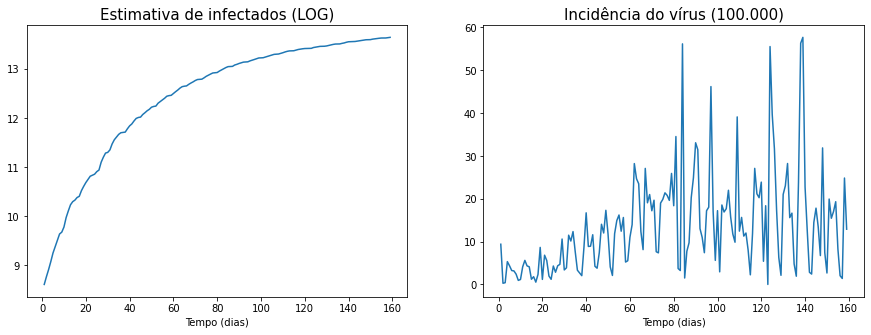

In [5]:
#Curvas de demandas por leitos de UTI
fig, axs = plt.subplots(1,2, figsize = (15,5))

axs[0].plot(sao_paulo["infectados_log"], label = 'São Paulo')
axs[0].set_title('Estimativa de infectados (LOG)', fontsize = 15)

axs[1].plot(sao_paulo['incidencia'], label = 'São Paulo')
axs[1].set_title('Incidência do vírus (100.000)', fontsize = 15)

for ax in fig.axes:
    plt.sca(ax)
    plt.xlabel('Tempo (dias)')

plt.show()

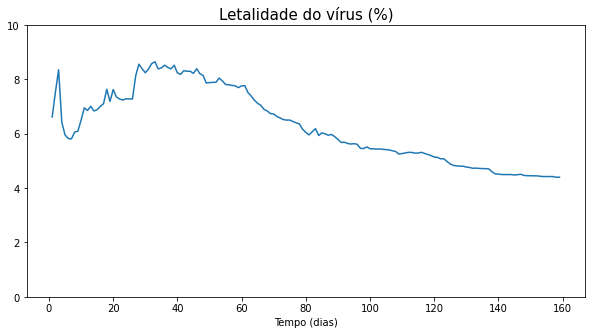

In [6]:
#Curvas de demandas por leitos de UTI
fig, axs = plt.subplots(figsize = (10,5))

axs.plot(sao_paulo['letalidade_01'] * 100, label = 'São Paulo')
axs.set_ylim([0,10])
axs.set_title('Letalidade do vírus (%)', fontsize = 15)

for ax in fig.axes:
    plt.sca(ax)
    plt.xlabel('Tempo (dias)')

plt.show()

___
## 4) Modelagem SIR para a cidade de São Paulo

O escopo deste capítulo envolve:
  * Definição das premissas da modelagem
  * Estimativas dos valores de $\beta$ e $R_0$


In [7]:
sao_paulo.head(2)

,regiao,estado,municipio,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,infectados,infectados_log,infectados_uti,data_estimada_acometimento,letalidade_01,prevalencia,incidencia
1,Sudeste,SP,São Paulo,SAO PAULO,2020-03-28,13,12252023.0,1149,1149,76,76,NaN,5507.246377,8.613820,335.942029,2020-03-10,0.066144,9.378043,9.378043
2,Sudeste,SP,São Paulo,SAO PAULO,2020-03-29,14,12252023.0,1183,34,89,13,NaN,6449.275362,8.771723,393.405797,2020-03-11,0.075232,9.655548,0.277505


### 4.1) Definição das premissas do modelo

In [8]:
# mortalidade do virus
d = 0.00504

# Tempo de recuperacao 
gamma = 1/21.939999999999998

# Valores de beta (taxa de contato entre os individuos da populacao)
betas = np.arange(0.0, 1.0, 0.01)

# População de São Paulo
N = sao_paulo['populacaoTCU2019'][1]
# Tempo de observação da dinâmica do patógeno
t = np.linspace(0, 400, 400)

# Estado inicial do modelo SIR
I0, R0 = 5507, 0
S0 = N - I0 - R0
y0 = S0, I0, R0

## 5) Modelagem da curva SIR para os dados, com a visão de 30, 45 e 90 dias

## 5.1) Estimativas dos parâmetros $\beta$ e $R_0$

* Separação dos dados em treinamento e teste
* Estimativa dos parâmetros
* Ajuste do modelo SIR
* Análise do ajuste
* Teste de cenários

#### Separação dos dados em treinamento e teste para a visão de 30 dias

In [9]:
tamanho_da_serie_de_sao_paulo = len(sao_paulo)
tamanho_do_treino = 30

sao_paulo_treino_30 = sao_paulo.iloc[:tamanho_do_treino]
sao_paulo_teste_30 = sao_paulo.iloc[tamanho_do_treino:]

print("Sao Paulo tem {} dias com dados sobre Corona Vírus".format(tamanho_da_serie_de_sao_paulo))
print(" --- Serão utilizados {} dados para treino e {} para teste".format(len(sao_paulo_treino_30), len(sao_paulo_teste_30)))
print(" --- Os dados de treino vão de {} à {}".format(sao_paulo_treino_30['data'].values[0], sao_paulo_treino_30['data'].values[-1]))
print(" --- Os dados de teste vão de {} à {}".format(sao_paulo_teste_30['data'].values[0], sao_paulo_teste_30['data'].values[-1]))
print("\n")

# Estimativa para 30 dias
melhor_beta_30, melhor_tempo_30 = estimativa_de_beta_SIR(sao_paulo_treino_30['infectados'], t)

# Estimativa da taxa de reproducao do virus
Taxa_de_reproducao_do_virus = R_0(melhor_beta_30, gamma, d)
print('\n')
print('Com base no método de mínimos quadrados, as melhores estimativas são:')
print(' --- Taxa de contato (Beta) = {}'.format(melhor_beta_30))
print(' --- Taxa de reproducao do virus (R_0) = {}'.format(round(Taxa_de_reproducao_do_virus,2)))
print(' --- Tempo estimado referente ao início da série de acometidos: t = {}'.format(melhor_tempo_30))

Sao Paulo tem 159 dias com dados sobre Corona Vírus
 --- Serão utilizados 30 dados para treino e 129 para teste
 --- Os dados de treino vão de 2020-03-28 à 2020-04-26
 --- Os dados de teste vão de 2020-04-27 à 2020-09-02


Resumo das estimativas
 --- Beta: 0.12
 --- O tempo mais adequado foi 10


Com base no método de mínimos quadrados, as melhores estimativas são:
 --- Taxa de contato (Beta) = 0.12
 --- Taxa de reproducao do virus (R_0) = 2.37
 --- Tempo estimado referente ao início da série de acometidos: t = 10


#### Separação dos dados em treinamento e teste para a visão de 45 dias

In [10]:
tamanho_da_serie_de_sao_paulo = len(sao_paulo)
tamanho_do_treino = 45

sao_paulo_treino_45 = sao_paulo.iloc[:tamanho_do_treino]
sao_paulo_teste_45 = sao_paulo.iloc[tamanho_do_treino:]

print("Sao Paulo tem {} dias com dados sobre Corona Vírus".format(tamanho_da_serie_de_sao_paulo))
print(" --- Serão utilizados {} dados para treino e {} para teste".format(len(sao_paulo_treino_45), len(sao_paulo_teste_45)))
print(" --- Os dados de treino vão de {} à {}".format(sao_paulo_treino_45['data'].values[0], sao_paulo_treino_45['data'].values[-1]))
print(" --- Os dados de teste vão de {} à {}".format(sao_paulo_teste_45['data'].values[0], sao_paulo_teste_45['data'].values[-1]))
print("\n")

# Estimativa para 30 dias
melhor_beta_45, melhor_tempo_45 = estimativa_de_beta_SIR(sao_paulo_treino_45['infectados'], t)

# Estimativa da taxa de reproducao do virus
Taxa_de_reproducao_do_virus = R_0(melhor_beta_45, gamma, d)
print('\n')
print('Com base no método de mínimos quadrados, as melhores estimativas são:')
print(' --- Taxa de contato (Beta) = {}'.format(melhor_beta_45))
print(' --- Taxa de reproducao do virus (R_0) = {}'.format(round(Taxa_de_reproducao_do_virus,2)))
print(' --- Tempo estimado referente ao início da série de acometidos: t = {}'.format(melhor_tempo_45))

Sao Paulo tem 159 dias com dados sobre Corona Vírus
 --- Serão utilizados 45 dados para treino e 114 para teste
 --- Os dados de treino vão de 2020-03-28 à 2020-05-11
 --- Os dados de teste vão de 2020-05-12 à 2020-09-02


Resumo das estimativas
 --- Beta: 0.11
 --- O tempo mais adequado foi 16


Com base no método de mínimos quadrados, as melhores estimativas são:
 --- Taxa de contato (Beta) = 0.11
 --- Taxa de reproducao do virus (R_0) = 2.17
 --- Tempo estimado referente ao início da série de acometidos: t = 16


#### Separação dos dados em treinamento e teste para a visão de 90 dias

In [11]:
tamanho_da_serie_de_sao_paulo = len(sao_paulo)
#tamanho_do_treino = int(0.8*tamanho_da_serie_de_sao_paulo)
tamanho_do_treino = 90

sao_paulo_treino_90 = sao_paulo.iloc[:tamanho_do_treino]
sao_paulo_teste_90 = sao_paulo.iloc[tamanho_do_treino:]

print("Sao Paulo tem {} dias com dados sobre Corona Vírus".format(tamanho_da_serie_de_sao_paulo))
print(" --- Serão utilizados {} dados para treino e {} para teste".format(len(sao_paulo_treino_90), len(sao_paulo_teste_90)))
print(" --- Os dados de treino vão de {} à {}".format(sao_paulo_treino_90['data'].values[0], sao_paulo_treino_90['data'].values[-1]))
print(" --- Os dados de teste vão de {} à {}".format(sao_paulo_teste_90['data'].values[0], sao_paulo_teste_90['data'].values[-1]))
print("\n")

# Estimativa para 30 dias
melhor_beta_90, melhor_tempo_90 = estimativa_de_beta_SIR(sao_paulo_treino_90['infectados'], t)

# Estimativa da taxa de reproducao do virus
Taxa_de_reproducao_do_virus = R_0(melhor_beta_90, gamma, d)
print('\n')
print('Com base no método de mínimos quadrados, as melhores estimativas são:')
print(' --- Taxa de contato (Beta) = {}'.format(melhor_beta_90))
print(' --- Taxa de reproducao do virus (R_0) = {}'.format(round(Taxa_de_reproducao_do_virus,2)))
print(' --- Tempo estimado referente ao início da série de acometidos: t = {}'.format(melhor_tempo_90))

Sao Paulo tem 159 dias com dados sobre Corona Vírus
 --- Serão utilizados 90 dados para treino e 69 para teste
 --- Os dados de treino vão de 2020-03-28 à 2020-06-25
 --- Os dados de teste vão de 2020-06-26 à 2020-09-02


Resumo das estimativas
 --- Beta: 0.08
 --- O tempo mais adequado foi 76


Com base no método de mínimos quadrados, as melhores estimativas são:
 --- Taxa de contato (Beta) = 0.08
 --- Taxa de reproducao do virus (R_0) = 1.58
 --- Tempo estimado referente ao início da série de acometidos: t = 76


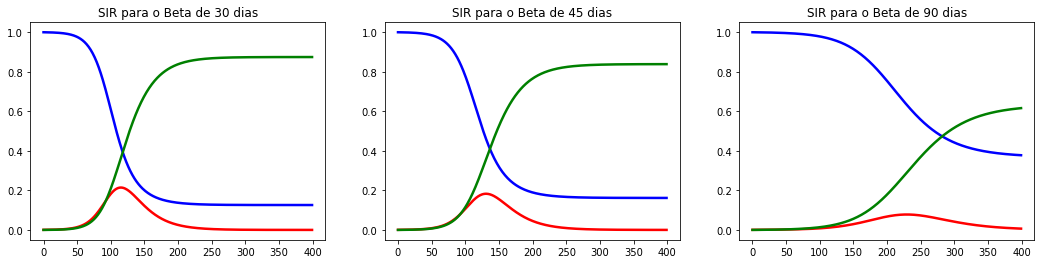

In [12]:
# Condicoes iniciais
y0 = S0, I0, R0

# Estimativa dos modelos
sir_30 = odeint(EDO, y0, t, args=(N, melhor_beta_30, gamma, d))
sir_45 = odeint(EDO, y0, t, args=(N, melhor_beta_45, gamma, d))
sir_90 = odeint(EDO, y0, t, args=(N, melhor_beta_90, gamma, d))

# Separação dos compartimentos
S_30, I_30, R_30 = sir_30.T
S_45, I_45, R_45 = sir_45.T
S_90, I_90, R_90 = sir_90.T

fig, axs = plt.subplots(1,3, figsize = (18,4))

axs[0].set_title('SIR para o Beta de 30 dias', fontsize = 12)
axs[0].plot(S_30/N, label = 'Suscetíveis', color = 'blue', linewidth = 2.5)
axs[0].plot(I_30/N, label = 'Infectados', color = 'red',linewidth = 2.5)
axs[0].plot(R_30/N, label = 'Removidos', color = 'green', linewidth = 2.5)

axs[1].set_title('SIR para o Beta de 45 dias', fontsize = 12)
axs[1].plot(S_45/N, label = 'Suscetíveis', color = 'blue', linewidth = 2.5)
axs[1].plot(I_45/N, label = 'Infectados', color = 'red',linewidth = 2.5)
axs[1].plot(R_45/N, label = 'Removidos', color = 'green', linewidth = 2.5)

axs[2].set_title('SIR para o Beta de 90 dias', fontsize = 12)
axs[2].plot(S_90/N, label = 'Suscetíveis', color = 'blue', linewidth = 2.5)
axs[2].plot(I_90/N, label = 'Infectados', color = 'red',linewidth = 2.5)
axs[2].plot(R_90/N, label = 'Removidos', color = 'green', linewidth = 2.5)

plt.show()

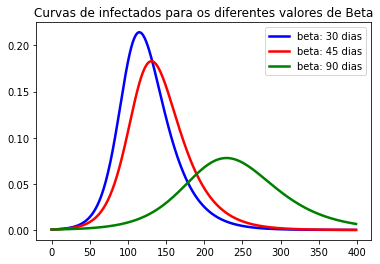

In [13]:
# Curvas de infectados
plt.title('Curvas de infectados para os diferentes valores de Beta', fontsize = 12)
plt.plot(I_30/N, label = 'beta: 30 dias', color = 'blue', linewidth = 2.5)
plt.plot(I_45/N, label = 'beta: 45 dias', color = 'red',linewidth = 2.5)
plt.plot(I_90/N, label = 'beta: 90 dias', color = 'green', linewidth = 2.5)
plt.legend()
plt.show()

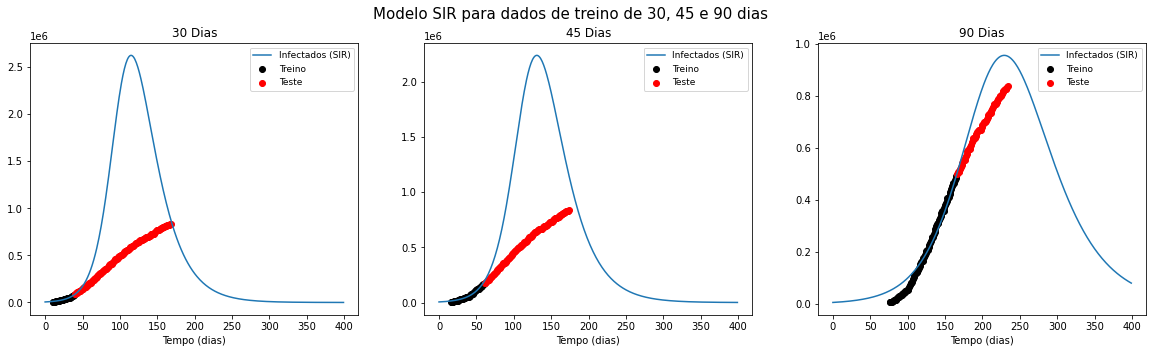

In [14]:
# ----
# Tratamento dos dados para realizacao do plot
# Modelo para 30 dias
sao_paulo_treino_editado_30 = list([np.nan for i in range(melhor_tempo_30)])
sao_paulo_treino_editado_30 = sao_paulo_treino_editado_30 + list(sao_paulo_treino_30['infectados'])
sao_paulo_treino_editado_30 = sao_paulo_treino_editado_30 + list([np.nan for i in range(len(I_30) - len(sao_paulo_treino_editado_30))])

sao_paulo_teste_editado_30 = list([np.nan for i in range(melhor_tempo_30)]) 
sao_paulo_teste_editado_30 = sao_paulo_teste_editado_30 + list([np.nan for i in range(len(sao_paulo_treino_30['infectados']))])
sao_paulo_teste_editado_30 = sao_paulo_teste_editado_30 + list(sao_paulo_teste_30['infectados'])
sao_paulo_teste_editado_30 = sao_paulo_teste_editado_30 + list([np.nan for i in range(len(I_30) - len(sao_paulo_teste_editado_30))])

# Modelo para 45 dias
sao_paulo_treino_editado_45 = list([np.nan for i in range(melhor_tempo_45)])
sao_paulo_treino_editado_45 = sao_paulo_treino_editado_45 + list(sao_paulo_treino_45['infectados'])
sao_paulo_treino_editado_45 = sao_paulo_treino_editado_45 + list([np.nan for i in range(len(I_45) - len(sao_paulo_treino_editado_45))])

sao_paulo_teste_editado_45 = list([np.nan for i in range(melhor_tempo_45)]) 
sao_paulo_teste_editado_45 = sao_paulo_teste_editado_45 + list([np.nan for i in range(len(sao_paulo_treino_45['infectados']))])
sao_paulo_teste_editado_45 = sao_paulo_teste_editado_45 + list(sao_paulo_teste_45['infectados'])
sao_paulo_teste_editado_45 = sao_paulo_teste_editado_45 + list([np.nan for i in range(len(I_45) - len(sao_paulo_teste_editado_45))])

# Modelo para 90 dias
sao_paulo_treino_editado_90 = list([np.nan for i in range(melhor_tempo_90)])
sao_paulo_treino_editado_90 = sao_paulo_treino_editado_90 + list(sao_paulo_treino_90['infectados'])
sao_paulo_treino_editado_90 = sao_paulo_treino_editado_90 + list([np.nan for i in range(len(I_90) - len(sao_paulo_treino_editado_90))])

sao_paulo_teste_editado_90 = list([np.nan for i in range(melhor_tempo_90)]) 
sao_paulo_teste_editado_90 = sao_paulo_teste_editado_90 + list([np.nan for i in range(len(sao_paulo_treino_90['infectados']))])
sao_paulo_teste_editado_90 = sao_paulo_teste_editado_90 + list(sao_paulo_teste_90['infectados'])
sao_paulo_teste_editado_90 = sao_paulo_teste_editado_90 + list([np.nan for i in range(len(I_90) - len(sao_paulo_teste_editado_90))])


# ----
# Graficos
fig, axs = plt.subplots(1,3, figsize = (20,5))
fig.suptitle('Modelo SIR para dados de treino de 30, 45 e 90 dias', fontsize = 15)

axs[0].plot(I_30, label = 'Infectados (SIR)')
axs[0].scatter(x = np.arange(len(sao_paulo_treino_editado_30)), y = sao_paulo_treino_editado_30, color = 'black', label = 'Treino')
axs[0].scatter(x = np.arange(len(sao_paulo_teste_editado_30)), y = sao_paulo_teste_editado_30, color = 'red', label = 'Teste')
axs[0].set_title('30 Dias', fontsize = 12)
axs[0].legend(fontsize = 9)

axs[1].plot(I_45, label = 'Infectados (SIR)')
axs[1].scatter(x = np.arange(len(sao_paulo_treino_editado_45)), y = sao_paulo_treino_editado_45, color = 'black', label = 'Treino')
axs[1].scatter(x = np.arange(len(sao_paulo_teste_editado_45)), y = sao_paulo_teste_editado_45, color = 'red', label = 'Teste')
axs[1].set_title('45 Dias', fontsize = 12)
axs[1].legend(fontsize = 9)

axs[2].plot(I_90, label = 'Infectados (SIR)')
axs[2].scatter(x = np.arange(len(sao_paulo_treino_editado_90)), y = sao_paulo_treino_editado_90, color = 'black', label = 'Treino')
axs[2].scatter(x = np.arange(len(sao_paulo_teste_editado_90)), y = sao_paulo_teste_editado_90, color = 'red', label = 'Teste')
axs[2].set_title('90 Dias', fontsize = 12)
axs[2].legend(fontsize = 9)

for ax in fig.axes:
    plt.sca(ax)
    plt.xlabel('Tempo (dias)', fontsize = 10)

plt.show()

### Cenários para a modelagem com 30 dias

In [15]:
cenario = 0.1

R_zero_otimista_30 = R_0(melhor_beta_30*(1-cenario), gamma, d)
R_zero_pessimista_30 = R_0(melhor_beta_30*(1+cenario), gamma, d)

print('No cenário otimista, as taxas seriam:')
print('--- beta = {}'.format(round(melhor_beta_30*(1-cenario), 2)))
print('--- R_0 = {}'.format(round(R_zero_otimista_30, 2)))
print('\n')
print('No cenário pessista, as taxas são:')
print('--- beta = {}'.format(round(melhor_beta_30*(1+cenario), 2)))
print('--- R_0 = {}'.format(round(R_zero_pessimista_30, 2)))

No cenário otimista, as taxas seriam:
--- beta = 0.11
--- R_0 = 2.13


No cenário pessista, as taxas são:
--- beta = 0.13
--- R_0 = 2.61


### Cenários para a modelagem com 45 dias

In [16]:
cenario = 0.1

R_zero_otimista_45 = R_0(melhor_beta_45*(1-cenario), gamma, d)
R_zero_pessimista_45 = R_0(melhor_beta_45*(1+cenario), gamma, d)

print('No cenário otimista, as taxas seriam:')
print('--- beta = {}'.format(round(melhor_beta_45*(1-cenario), 2)))
print('--- R_0 = {}'.format(round(R_zero_otimista_45, 2)))
print('\n')
print('No cenário pessista, as taxas são:')
print('--- beta = {}'.format(round(melhor_beta_45*(1+cenario), 2)))
print('--- R_0 = {}'.format(round(R_zero_pessimista_45, 2)))

No cenário otimista, as taxas seriam:
--- beta = 0.1
--- R_0 = 1.96


No cenário pessista, as taxas são:
--- beta = 0.12
--- R_0 = 2.39


### Cenários para a modelagem com 90 dias

In [17]:
cenario = 0.1

R_zero_otimista_90 = R_0(melhor_beta_90*(1-cenario), gamma, d)
R_zero_pessimista_90 = R_0(melhor_beta_90*(1+cenario), gamma, d)

print('No cenário otimista, as taxas seriam:')
print('--- beta = {}'.format(round(melhor_beta_90*(1-cenario), 2)))
print('--- R_0 = {}'.format(round(R_zero_otimista_90, 2)))
print('\n')
print('No cenário pessista, as taxas são:')
print('--- beta = {}'.format(round(melhor_beta_90*(1+cenario), 2)))
print('--- R_0 = {}'.format(round(R_zero_pessimista_90, 2)))

No cenário otimista, as taxas seriam:
--- beta = 0.07
--- R_0 = 1.42


No cenário pessista, as taxas são:
--- beta = 0.09
--- R_0 = 1.74


In [18]:
# SIR Otimista
ret_otimista_30 = odeint(EDO, y0, t, args=(N, melhor_beta_30*(1-cenario), gamma, d))
ret_otimista_45 = odeint(EDO, y0, t, args=(N, melhor_beta_45*(1-cenario), gamma, d))
ret_otimista_90 = odeint(EDO, y0, t, args=(N, melhor_beta_90*(1-cenario), gamma, d))

_, I_otimista_30, _ = ret_otimista_30.T
_, I_otimista_45, _ = ret_otimista_45.T
_, I_otimista_90, _ = ret_otimista_90.T

# Sir pessismista
ret_pessimista_30 = odeint(EDO, y0, t, args=(N, melhor_beta_30*(1+cenario), gamma, d))
ret_pessimista_45 = odeint(EDO, y0, t, args=(N, melhor_beta_45*(1+cenario), gamma, d))
ret_pessimista_90 = odeint(EDO, y0, t, args=(N, melhor_beta_90*(1+cenario), gamma, d))

_, I_pessimista_30, _ = ret_pessimista_30.T
_, I_pessimista_45, _ = ret_pessimista_45.T
_, I_pessimista_90, _ = ret_pessimista_90.T

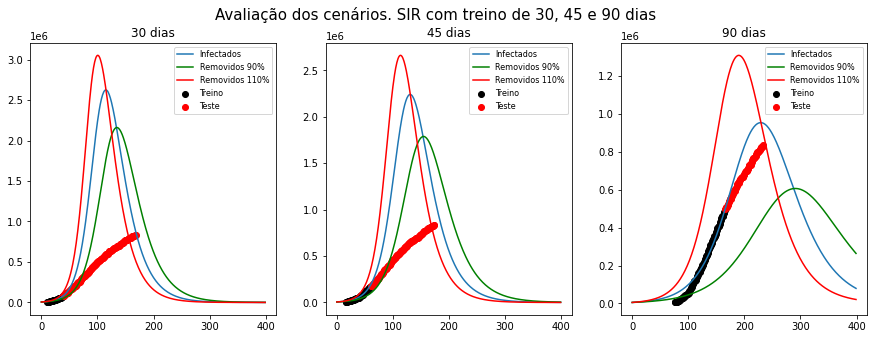

In [31]:
fig, axs = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('Avaliação dos cenários. SIR com treino de 30, 45 e 90 dias', fontsize = 15)

axs[0].plot(I_30, label = 'Infectados')
axs[0].set_title('30 dias', fontsize = 12)
axs[0].plot(I_otimista_30, label = 'Removidos 90%', color = 'green')
axs[0].plot(I_pessimista_30, label = 'Removidos 110%', color = 'red')
axs[0].scatter(x = np.arange(len(sao_paulo_treino_editado_30)), y = sao_paulo_treino_editado_30, color = 'black', label = 'Treino')
axs[0].scatter(x = np.arange(len(sao_paulo_teste_editado_30)), y = sao_paulo_teste_editado_30, color = 'red', label = 'Teste')
axs[0].legend(fontsize = 8)

axs[1].plot(I_45, label = 'Infectados')
axs[1].set_title('45 dias', fontsize = 12)
axs[1].plot(I_otimista_45, label = 'Removidos 90%', color = 'green')
axs[1].plot(I_pessimista_45, label = 'Removidos 110%', color = 'red')
axs[1].scatter(x = np.arange(len(sao_paulo_treino_editado_45)), y = sao_paulo_treino_editado_45, color = 'black', label = 'Treino')
axs[1].scatter(x = np.arange(len(sao_paulo_teste_editado_45)), y = sao_paulo_teste_editado_45, color = 'red', label = 'Teste')
axs[1].legend(fontsize = 8)

axs[2].plot(I_90, label = 'Infectados')
axs[2].set_title('90 dias', fontsize = 12)
axs[2].plot(I_otimista_90, label = 'Removidos 90%', color = 'green')
axs[2].plot(I_pessimista_90, label = 'Removidos 110%', color = 'red')
axs[2].scatter(x = np.arange(len(sao_paulo_treino_editado_90)), y = sao_paulo_treino_editado_90, color = 'black', label = 'Treino')
axs[2].scatter(x = np.arange(len(sao_paulo_teste_editado_90)), y = sao_paulo_teste_editado_90, color = 'red', label = 'Teste')
axs[2].legend(fontsize = 8)

plt.show()

### 5.3) Estimativa acumulada do número de leitos de UTI

* **Estimativa do número de infectados com necessidade de UTI**

\

\begin{equation}
infectados-com-necessidade-de-uti = 0.011 * infectados \tag{2}
\end{equation}

\

In [32]:
tamanho_da_serie_de_sao_paulo = len(sao_paulo)
tamanho_do_treino = int(0.85 * tamanho_da_serie_de_sao_paulo)

sao_paulo_treino = sao_paulo.iloc[:tamanho_do_treino]
sao_paulo_teste = sao_paulo.iloc[tamanho_do_treino:]

print("Sao Paulo tem {} dias com dados sobre Corona Vírus".format(tamanho_da_serie_de_sao_paulo))
print(" --- Serão utilizados {} dados para treino e {} para teste".format(len(sao_paulo_treino), len(sao_paulo_teste)))
print(" --- Os dados de treino vão de {} à {}".format(sao_paulo_treino['data'].values[0], sao_paulo_treino['data'].values[-1]))
print(" --- Os dados de teste vão de {} à {}".format(sao_paulo_teste['data'].values[0], sao_paulo_teste['data'].values[-1]))
print("\n")

# Estimativa para 30 dias
melhor_beta, melhor_tempo = estimativa_de_beta_SIR(sao_paulo_treino['infectados'], t)

# Estimativa da taxa de reproducao do virus
Taxa_de_reproducao_do_virus = R_0(melhor_beta, gamma, d)
print('\n')
print('Com base no método de mínimos quadrados, as melhores estimativas são:')
print(' --- Taxa de contato (Beta) = {}'.format(melhor_beta))
print(' --- Taxa de reproducao do virus (R_0) = {}'.format(round(Taxa_de_reproducao_do_virus,2)))
print(' --- Tempo estimado referente ao início da série de acometidos: t = {}'.format(melhor_tempo))

Sao Paulo tem 159 dias com dados sobre Corona Vírus
 --- Serão utilizados 135 dados para treino e 24 para teste
 --- Os dados de treino vão de 2020-03-28 à 2020-08-09
 --- Os dados de teste vão de 2020-08-10 à 2020-09-02


Resumo das estimativas
 --- Beta: 0.08
 --- O tempo mais adequado foi 70


Com base no método de mínimos quadrados, as melhores estimativas são:
 --- Taxa de contato (Beta) = 0.08
 --- Taxa de reproducao do virus (R_0) = 1.58
 --- Tempo estimado referente ao início da série de acometidos: t = 70


In [41]:
# Estimativa dos modelos
sir_otimista = odeint(EDO, y0, t, args=(N, melhor_beta*(1-cenario), gamma, d))
sir = odeint(EDO, y0, t, args=(N, melhor_beta, gamma, d))
sir_pessimista = odeint(EDO, y0, t, args=(N, melhor_beta*(1+cenario), gamma, d))

# Separação dos compartimentos
S, I_otimista, R = sir_otimista.T
S, I, R = sir.T
S, I_pessimista, R = sir_pessimista.T

# Construção dos cenários
curva_SIR_infectados_com_necessidade_de_uti = 0.011 * I
curva_SIR_otimista_infectados_com_necessidade_de_uti = 0.011 * I_otimista
curva_SIR_pessimista_infectados_com_necessidade_de_uti = 0.011 * I_pessimista

# Preparação dos dados para plot das curvas
sao_paulo_treino_editado = list([np.nan for i in range(melhor_tempo)])
sao_paulo_treino_editado = sao_paulo_treino_editado + list(sao_paulo_treino['infectados'])
sao_paulo_treino_editado = sao_paulo_treino_editado + list([np.nan for i in range(len(I) - len(sao_paulo_treino_editado))])

sao_paulo_teste_editado = list([np.nan for i in range(estimativa_inicio_da_serie)]) 
sao_paulo_teste_editado = sao_paulo_teste_editado + list([np.nan for i in range(len(sao_paulo_treino['infectados']))])
sao_paulo_teste_editado = sao_paulo_teste_editado + list(sao_paulo_teste['infectados'])
sao_paulo_teste_editado = sao_paulo_teste_editado +  list([np.nan for i in range(len(I) - len(sao_paulo_teste_editado))])

estimativa_de_infectados_com_necessidade_de_uti_sao_paulo_treino = [np.nan if i == np.nan else 0.011 * i for i in sao_paulo_treino_editado]
estimativa_de_infectados_com_necessidade_de_uti_sao_paulo_teste = [np.nan if i == np.nan else 0.011 * i for i in sao_paulo_teste_editado]

In [42]:
curva_SIR_infectados_com_necessidade_de_uti = 0.011 * I
curva_SIR_otimista_infectados_com_necessidade_de_uti = 0.011 * I_otimista
curva_SIR_pessimista_infectados_com_necessidade_de_uti = 0.011 * I_pessimista

estimativa_de_infectados_com_necessidade_de_uti_sao_paulo_treino = [np.nan if i == np.nan else 0.011 * i for i in sao_paulo_treino_editado]
estimativa_de_infectados_com_necessidade_de_uti_sao_paulo_teste = [np.nan if i == np.nan else 0.011 * i for i in sao_paulo_teste_editado]

In [43]:
# Preparando o vetor de data para plotar no gráfico final
sao_paulo_data_minima = min(sao_paulo_treino['data_estimada_acometimento'])
sao_paulo_data_minima = datetime(int(sao_paulo_data_minima[:4]), int(sao_paulo_data_minima[5:7]), int(sao_paulo_data_minima[8:]))
sao_paulo_data_minima = sao_paulo_data_minima + timedelta(-150)
sao_paulo_serie_data = [sao_paulo_data_minima+timedelta(i) for i in range(400)]
sao_paulo_serie_data = [datetime.date(i) for i in sao_paulo_serie_data]

In [44]:
tabela_demanda_por_leitos_uti = pd.DataFrame({'Data_estimada' : sao_paulo_serie_data, 
                                              'Infectados_UTI_SIR' : curva_SIR_infectados_com_necessidade_de_uti,
                                              'Infectados_UTI_SIR_otimista' : curva_SIR_otimista_infectados_com_necessidade_de_uti,
                                              'Infectados_UTI_SIR_pessimista' : curva_SIR_pessimista_infectados_com_necessidade_de_uti,
                                              'Estimativa_infectados_treino' : estimativa_de_infectados_com_necessidade_de_uti_sao_paulo_treino,
                                              'Estimativa_infectados_teste' : estimativa_de_infectados_com_necessidade_de_uti_sao_paulo_teste})

tabela_filtrada = tabela_demanda_por_leitos_uti.iloc[10:250]

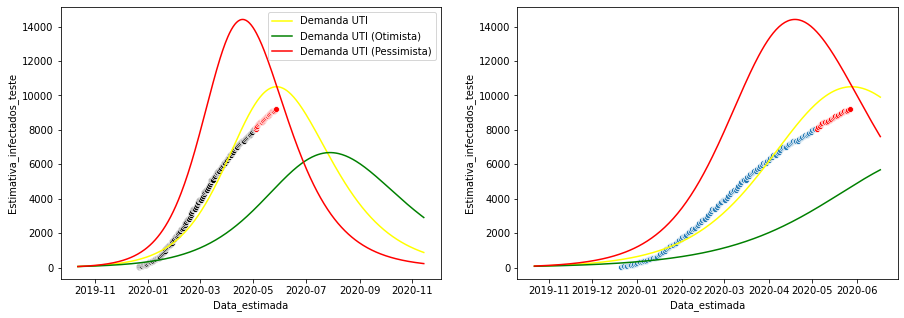

In [45]:
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.lineplot(x="Data_estimada", y="Infectados_UTI_SIR", data=tabela_demanda_por_leitos_uti, ax = ax1, color = 'yellow', label = 'Demanda UTI')
sns.lineplot(x="Data_estimada", y="Infectados_UTI_SIR_otimista", data=tabela_demanda_por_leitos_uti, ax = ax1, color = 'green', label = 'Demanda UTI (Otimista)')
sns.lineplot(x="Data_estimada", y="Infectados_UTI_SIR_pessimista", data=tabela_demanda_por_leitos_uti, ax = ax1, color = 'red', label = 'Demanda UTI (Pessimista)')
sns.scatterplot(x = "Data_estimada", y = "Estimativa_infectados_treino",  data=tabela_demanda_por_leitos_uti, ax = ax1, color = 'black')
sns.scatterplot(x = "Data_estimada", y = "Estimativa_infectados_teste",  data=tabela_demanda_por_leitos_uti, ax = ax1, color = 'red')

sns.lineplot(x="Data_estimada", y="Infectados_UTI_SIR", data=tabela_filtrada, ax = ax2, color = 'yellow')
sns.lineplot(x="Data_estimada", y="Infectados_UTI_SIR_otimista", data=tabela_filtrada, ax = ax2, color = 'green')
sns.lineplot(x="Data_estimada", y="Infectados_UTI_SIR_pessimista", data=tabela_filtrada, ax = ax2, color = 'red')
sns.scatterplot(x = "Data_estimada", y = "Estimativa_infectados_treino",  data=tabela_filtrada, ax = ax2)
sns.scatterplot(x = "Data_estimada", y = "Estimativa_infectados_teste",  data=tabela_filtrada, ax = ax2, color = 'red')

plt.show()

### 5.4) Estimativa do número de leitos de UTI

In [46]:
# Estimativa de leitos
tabela_filtrada_dados_nao_acumulados = tabela_demanda_por_leitos_uti.copy()
tabela_filtrada_dados_nao_acumulados = tabela_filtrada_dados_nao_acumulados.diff(25)[['Infectados_UTI_SIR','Infectados_UTI_SIR_otimista','Infectados_UTI_SIR_pessimista']]
tabela_filtrada_dados_nao_acumulados['Data_estimada'] = tabela_demanda_por_leitos_uti['Data_estimada']

# Correcao dos valores
tabela_filtrada_dados_nao_acumulados['Infectados_UTI_SIR']            = [0 if i < 0 else i for i in tabela_filtrada_dados_nao_acumulados['Infectados_UTI_SIR']]
tabela_filtrada_dados_nao_acumulados['Infectados_UTI_SIR_otimista']   = [0 if i < 0 else i for i in tabela_filtrada_dados_nao_acumulados['Infectados_UTI_SIR_otimista']]
tabela_filtrada_dados_nao_acumulados['Infectados_UTI_SIR_pessimista'] = [0 if i < 0 else i for i in tabela_filtrada_dados_nao_acumulados['Infectados_UTI_SIR_pessimista']]

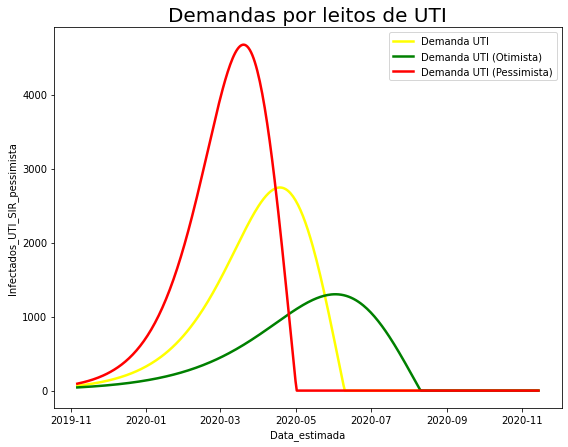

In [47]:
fig = plt.figure(figsize = (20,7))
ax1 = fig.add_subplot(121)

plt.title('Demandas por leitos de UTI', fontsize = 20)
sns.lineplot(x="Data_estimada", y="Infectados_UTI_SIR", data=tabela_filtrada_dados_nao_acumulados, ax = ax1, color = 'yellow', label = 'Demanda UTI', linewidth = 2.5)
sns.lineplot(x="Data_estimada", y="Infectados_UTI_SIR_otimista", data=tabela_filtrada_dados_nao_acumulados, ax = ax1, color = 'green', label = 'Demanda UTI (Otimista)', linewidth = 2.5)
sns.lineplot(x="Data_estimada", y="Infectados_UTI_SIR_pessimista", data=tabela_filtrada_dados_nao_acumulados, ax = ax1, color = 'red', label = 'Demanda UTI (Pessimista)', linewidth = 2.5)

plt.show()

In [ ]:
tabela_filtrada_dados_nao_acumulados.loc[150:]